In [2]:
import numpy as np
import pandas as pd
import os
import warnings

In [3]:
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=15.5)    # legend fontsize
plt.rc('figure', titlesize=50)  # fontsize of the figure title

In [5]:
header = ['user_id','item_id','rating','timestamp']
dataset = pd.read_csv('../data/ml-100k/u.data',sep = '\t',names = header)
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
n_items = len(pd.unique(dataset['item_id']))
n_users = len(pd.unique(dataset['user_id']))
n_users, n_items

(943, 1682)

In [7]:
train, test_temp = train_test_split(dataset, test_size=0.2, random_state=42)
val, test = train_test_split(test_temp, test_size=0.5, random_state=42)

In [8]:
model_num = 1000
n_factors = 5
n_nodes_per_layer = [128, 64, 32, 16, 8, 4]
lr = 0.2
dropout_prob = 0.2
epochs = 10
batch_size = 256

# creating item embedding path
movie_input = Input(shape=[1], name="Item-Input")
movie_embedding = Embedding(n_items+1, 5, name="Item-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Items")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([movie_vec, user_vec])

# add fully-connected-layers
dense = Dense(n_nodes_per_layer[0], activation='relu')(conc)
dropout = Dropout(0.2)(dense)
batch_norm = BatchNormalization()(dropout)

for i, n_nodes in enumerate(n_nodes_per_layer[1:-1]):
    # add fully-connected-layers
    dense = Dense(n_nodes, activation='relu')(batch_norm)
    dropout = Dropout(dropout_prob)(dense)
    batch_norm = BatchNormalization()(dropout)

dense = Dense(n_nodes_per_layer[-1], activation='relu')(batch_norm)
out = Dense(1)(dense)

# Create model and compile it
model = Model([user_input, movie_input], out)
model.compile(optimizer=Adam(learning_rate=lr), loss=MeanSquaredError())
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 5)         8415        Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User-Input[0][0]                 
______________________________________________________________________________________________

In [9]:
history = model.fit(x = [train.user_id, train.item_id], y = train.rating, validation_data = ((val.user_id, val.item_id), val.rating), epochs=epochs, verbose=1, batch_size = batch_size)

Epoch 1/10
313/313 [==============================] - 3s 4ms/step - loss: 1.6514 - val_loss: 1.1907
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 1.1326 - val_loss: 1.0652
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 1.0117 - val_loss: 1.0355
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 1.0157 - val_loss: 0.9924
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.9609 - val_loss: 0.9434
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 0.9438 - val_loss: 0.9714
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 0.9416 - val_loss: 0.9295
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 0.9264 - val_loss: 0.9664
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 0.9091 - val_loss: 0.9386
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 0.9090 - val_loss: 0.9753

Text(0.5, 1.0, 'Model 1000: Loss Curves')

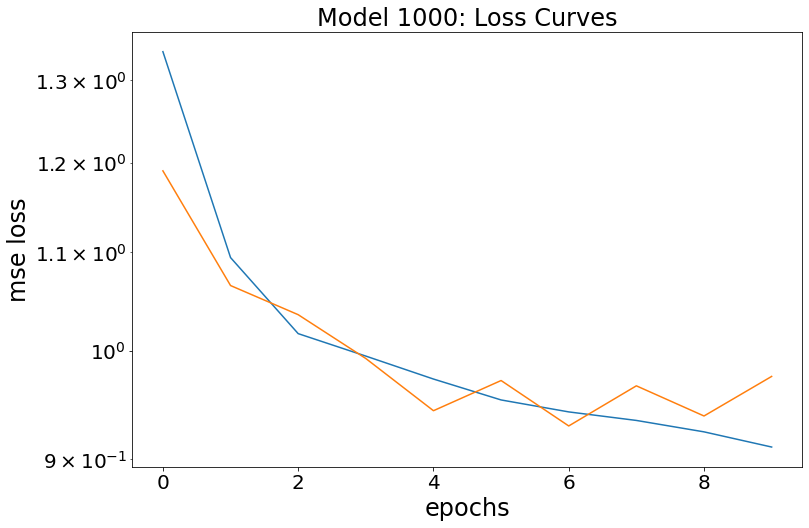

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label = 'train')
plt.plot(val_loss, label = 'val')
plt.yscale('log')
plt.ylabel('mse loss')
plt.xlabel('epochs')
plt.title(f'Model {model_num}: Loss Curves')
# plt.savefig(f'models/model_{model_num}/figures/loss.png')

In [11]:
predictions = model.predict([test.user_id, test.item_id])
preds_std = np.std(predictions)

predictions_list = []
for pred_rating in predictions:
    predictions_list.append(pred_rating[0])
    
ratings_preds_array = np.array(predictions_list).astype('float64')
ratings_actual_array = np.array(test.rating)

test_mse = mean_squared_error(ratings_actual_array, ratings_preds_array)

# make csv with ensemble info
model_info_header_list = ['model', 'test mse', 'test preds std', 'epochs', 'learning rate', 'n_nodes_per_layer', 'n_factors', 'batch_size', 'dropout_prob']
model_info_val_list = [[model_num, test_mse, preds_std, epochs, lr, n_nodes_per_layer, n_factors, batch_size, dropout_prob]]

model_info_df = pd.DataFrame(model_info_val_list, columns = model_info_header_list)


In [135]:
import pandas as pd
model_info_all_list = []
for model_num in range(96):
    model_info_df = pd.read_csv(f'models/model_{model_num}/model_info.csv')
    model_info_single_list = list(model_info_df.iloc[0])[1:]
    model_info_all_list.append(model_info_single_list)


In [136]:
model_info_header_list = ['model', 'test mse', 'test preds std', 'epochs', 'learning rate', 'n_nodes_per_layer', 'n_factors', 'batch_size', 'dropout_prob']
model_info_all_df = pd.DataFrame.from_records(model_info_all_list, columns = model_info_header_list)

In [137]:
model_info_all_df.sort_values('test mse')

,model,test mse,test preds std,epochs,learning rate,n_nodes_per_layer,n_factors,batch_size,dropout_prob
49,49,0.874936,0.680089,25,0.010000,"[256, 128, 64, 32, 16, 8, 4, 2]",5,256,0.2
62,62,0.887147,0.568500,25,0.001000,"[256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2
85,85,0.894681,0.605360,25,0.010000,"[128, 64, 32, 16, 8, 4, 2]",50,256,0.2
73,73,0.895819,0.659334,25,0.010000,"[128, 64, 32, 16, 8, 4, 2]",5,256,0.2
32,32,0.896015,0.641887,25,0.001000,"[512, 256, 128, 64, 32, 16, 8, 4, 2]",25,256,0.2
...,...,...,...,...,...,...,...,...,...
23,23,15.122653,0.147727,25,0.000001,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",100,256,0.2
95,95,15.701981,0.403502,25,0.000001,"[128, 64, 32, 16, 8, 4, 2]",100,256,0.2
53,53,15.923357,0.587195,25,0.000001,"[256, 128, 64, 32, 16, 8, 4, 2]",5,256,0.2
17,17,16.833619,0.392255,25,0.000001,"[1024, 512, 256, 128, 64, 32, 16, 8, 4, 2]",50,256,0.2


# Gather predicted ratings per user

In [14]:
ratings_per_user_dict = {}
test_user_id_list = list(test.user_id)
test_item_id_list = list(test.item_id)
unique_user_id_list = list(np.unique(test.user_id))
for i in range(len(unique_user_id_list)):
    ratings_per_user_dict[unique_user_id_list[i]] = []

for i in range(len(test.user_id)):
    ratings_per_user_dict[test_user_id_list[i]].append((test_item_id_list[i], ratings_preds_array[i]))

In [19]:
top_n = 5

sorted(ratings_per_user_dict[340], key = lambda x: x[1], reverse = True)[:top_n]

[(174, 3.9678072929382324),
 (173, 3.9067201614379883),
 (196, 3.8937885761260986),
 (1, 3.88016939163208),
 (211, 3.8553123474121094)]